In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [18]:
df = pd.read_csv('HistoricalQuotes.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")


Dataset shape: (2518, 6)
Columns: ['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low']


In [19]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


## Data Preprocessing

In [5]:
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
print(f"Date range: {df.index.min()} to {df.index.max()}")


Date range: 2010-03-01 00:00:00 to 2020-02-28 00:00:00


In [6]:
price_columns = ['Close/Last', 'Open', 'High', 'Low']
for col in price_columns:
    df[col] = df[col].str.replace('$', '').astype(float)
close_prices = df['Close/Last'].copy()
print(f"Close price range: ${close_prices.min():.2f} - ${close_prices.max():.2f}")


Close price range: $29.84 - $327.20


In [7]:
missing_values = close_prices.isnull().sum()
print(f"Missing values: {missing_values}")


Missing values: 0


In [8]:
lookback_period = 5
features = pd.DataFrame(index=close_prices.index)
for i in range(1, lookback_period + 1):
    features[f'lag_{i}'] = close_prices.shift(i)
features['target'] = close_prices
features.shape


(2518, 6)

In [9]:
features_clean = features.dropna()
print(f"Clean dataset shape: {features_clean.shape}")
X = features_clean.drop('target', axis=1)
y = features_clean['target']
print(f"Features shape: {X.shape}, Target shape: {y.shape}")


Clean dataset shape: (2513, 6)
Features shape: (2513, 5), Target shape: (2513,)


In [10]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()
print(f"Scaled features range: {X_scaled.min():.3f} to {X_scaled.max():.3f}")
print(f"Scaled target range: {y_scaled.min():.3f} to {y_scaled.max():.3f}")


Scaled features range: 0.000 to 1.000
Scaled target range: 0.000 to 1.000


In [11]:
split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 2010 samples
Test set: 503 samples


## Model Training

In [12]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred_scaled = lr_model.predict(X_test)
print("Linear Regression model trained successfully")
print(f"Model score on training data: {lr_model.score(X_train, y_train):.4f}")


Linear Regression model trained successfully
Model score on training data: 0.9985


In [13]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=0.8,
    bootstrap=True,
    oob_score=True
)
rf_model.fit(X_train, y_train)
rf_pred_scaled = rf_model.predict(X_test)
print("Random Forest model trained successfully")
print(f"Model score on training data: {rf_model.score(X_train, y_train):.4f}")
print(f"Model score on test data: {rf_model.score(X_test, y_test):.4f}")
print(f"Out of bag score: {rf_model.oob_score_:.4f}")

Random Forest model trained successfully
Model score on training data: 0.9991
Model score on test data: -0.5975
Out of bag score: 0.9982


## Model Evaluation

In [14]:
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
lr_pred_actual = scaler_y.inverse_transform(lr_pred_scaled.reshape(-1, 1)).ravel()
rf_pred_actual = scaler_y.inverse_transform(rf_pred_scaled.reshape(-1, 1)).ravel()
print(f"Actual prices range: ${y_test_actual.min():.2f} - ${y_test_actual.max():.2f}")
print(f"LR predictions range: ${lr_pred_actual.min():.2f} - ${lr_pred_actual.max():.2f}")
print(f"RF predictions range: ${rf_pred_actual.min():.2f} - ${rf_pred_actual.max():.2f}")

Actual prices range: $142.19 - $327.20
LR predictions range: $141.73 - $327.40
RF predictions range: $147.63 - $177.17


In [15]:
lr_mse = mean_squared_error(y_test_actual, lr_pred_actual)
rf_mse = mean_squared_error(y_test_actual, rf_pred_actual)
print(f"Linear Regression MSE: {lr_mse:.4f}")
print(f"Random Forest MSE: {rf_mse:.4f}")
better_model = "Random Forest" if rf_mse < lr_mse else "Linear Regression"

Linear Regression MSE: 13.6085
Random Forest MSE: 2774.0727


## Visualization

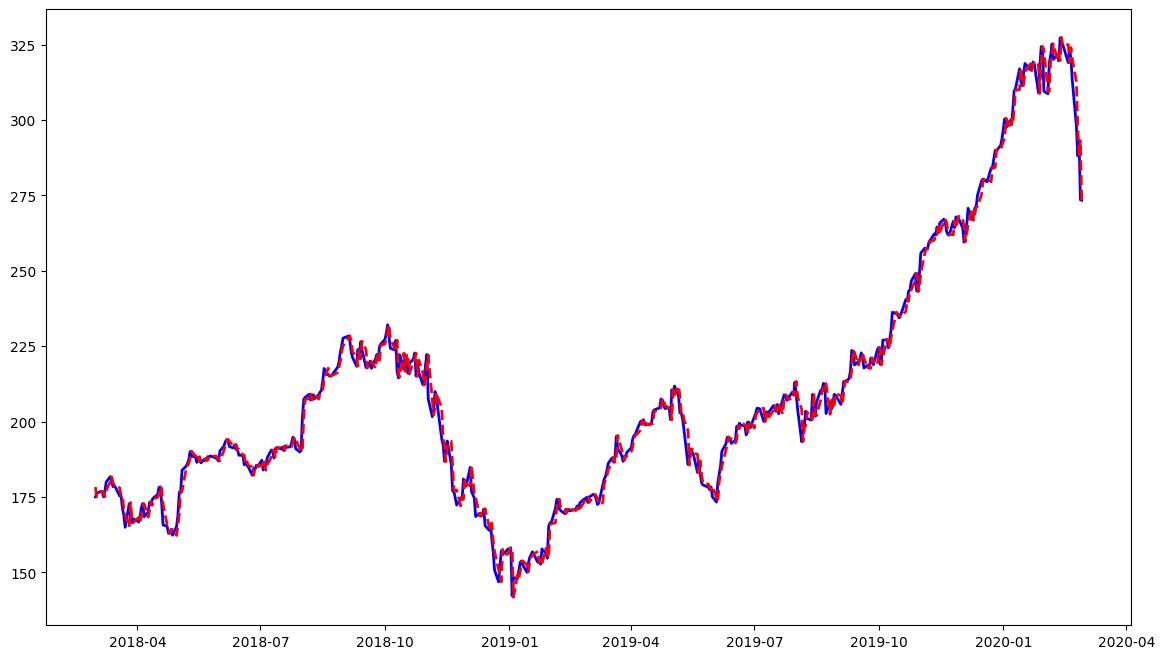

In [16]:
test_dates = features_clean.index[split_idx:]
plt.figure(figsize=(14, 8))
plt.plot(test_dates, y_test_actual, label='Actual Prices', color='blue', linewidth=2)
plt.plot(test_dates, lr_pred_actual, label='Linear Regression', color='red', linestyle='--', linewidth=2)


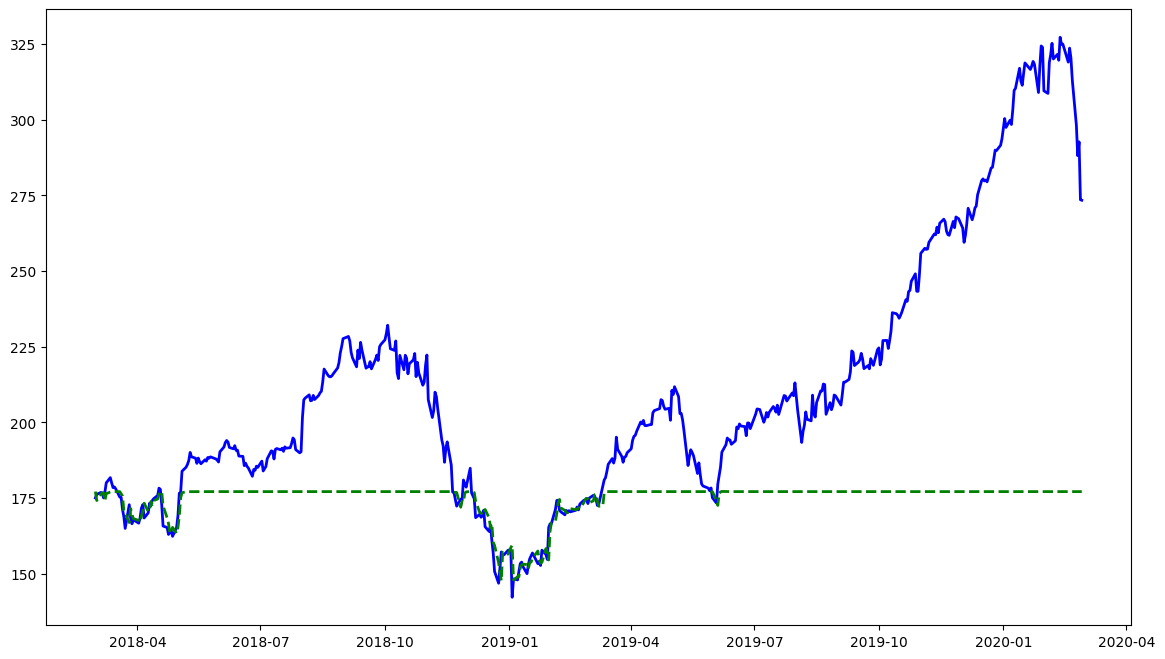

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(test_dates, y_test_actual, label='Actual Prices', color='blue', linewidth=2)
plt.plot(test_dates, rf_pred_actual, label='Random Forest', color='green', linestyle='--', linewidth=2)
plt.title('Random Forest vs Actual Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os

tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [ ]:
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Original X_train shape: {X_train.shape}")
print(f"LSTM X_train shape: {X_train_lstm.shape}")
print(f"Original X_test shape: {X_test.shape}")
print(f"LSTM X_test shape: {X_test_lstm.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


In [ ]:
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

lstm_model = create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
lstm_model.summary()


In [ ]:
print("Training LSTM model...")

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("LSTM model training completed!")


In [ ]:
lstm_pred_scaled = lstm_model.predict(X_test_lstm)
lstm_pred_actual = scaler_y.inverse_transform(lstm_pred_scaled).ravel()

print(f"LSTM predictions range: ${lstm_pred_actual.min():.2f} - ${lstm_pred_actual.max():.2f}")

lstm_mse = mean_squared_error(y_test_actual, lstm_pred_actual)
print(f"LSTM MSE: {lstm_mse:.4f}")

print("\n=== Model Performance Comparison ===")
print(f"Linear Regression MSE: {lr_mse:.4f}")
print(f"Random Forest MSE: {rf_mse:.4f}")
print(f"LSTM MSE: {lstm_mse:.4f}")


In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('LSTM Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Comprehensive comparison visualization
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 4)
plt.plot(test_dates, y_test_actual, label='Actual Prices', color='blue', linewidth=2)
plt.plot(test_dates, lstm_pred_actual, label='LSTM', color='purple', linestyle='--', linewidth=2)
plt.title('LSTM vs Actual')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Final Analysis and Summary
print("=== FINAL STOCK PRICE PREDICTION ANALYSIS ===\n")

# Calculate additional metrics
from sklearn.metrics import mean_absolute_error, r2_score

def calculate_metrics(actual, predicted, model_name):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"{model_name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE: ${mae:.2f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print()
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

# Calculate metrics for all models
lr_metrics = calculate_metrics(y_test_actual, lr_pred_actual, "Linear Regression")
rf_metrics = calculate_metrics(y_test_actual, rf_pred_actual, "Random Forest")
lstm_metrics = calculate_metrics(y_test_actual, lstm_pred_actual, "LSTM")

# Summary
print("=== SUMMARY ===")
print(f"Dataset: {len(close_prices)} total samples, {len(y_test)} test samples")
print(f"Time period: {df.index.min().date()} to {df.index.max().date()}")
print(f"Price range: ${close_prices.min():.2f} - ${close_prices.max():.2f}")
print(f"Best performing model: {best_model}")
print(f"Training epochs completed: {len(history.history['loss'])}")
print("\nThe LSTM model uses a deep learning approach with memory capabilities")
print("suitable for time series data like stock prices.")
